In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as st
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import cluster, metrics

### Mission 1
Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :

- analyse de l'éboulis des valeurs propres ;
- représentation des variables par le cercle des corrélations ;
- représentation des individus par les plans factoriels ;
- analyse de la qualité de représentation et la contribution des individus.

Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

In [2]:
#Importation du fichier source
data = pd.read_csv(r"C:\Users\elodi\Documents\DATA\Data Analyst\Projets\P6\notes.csv")

### Analyse en composantes principales 

#### 1. Préparation des données

In [3]:
acp_data = data.iloc[:, 1:]

In [4]:
#Préparation des données (tableau numpy)
X = acp_data.values
X.shape

(170, 6)

In [5]:
#Centrage et réduction des données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [6]:
#Choix du nombre de composantes
df_pca = PCA(n_components=6)
df_pca.fit(X_scaled)
X_df_pca = df_pca.transform(X_scaled)

In [7]:
#Pourcentage de variance expliquée par les composantes principales à l'aide de .explained_variance_ratio_
print((sum(df_pca.explained_variance_ratio_*100)))

100.0


In [8]:
#Variance expliquée en %
print(np.cumsum(df_pca.explained_variance_ratio_*100)[0])
print(np.cumsum(df_pca.explained_variance_ratio_*100)[1])
print(np.cumsum(df_pca.explained_variance_ratio_*100)[2])
print(np.cumsum(df_pca.explained_variance_ratio_*100)[5])

47.447920578848205
69.40502654128306
83.63955086800473
100.0


#### 2. Eboulis des valeurs propres

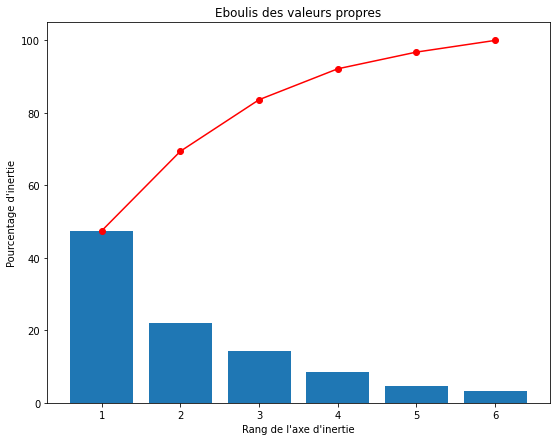

In [9]:
X_projected = X_df_pca
scree = df_pca.explained_variance_ratio_*100

plt.figure(figsize=(9, 7))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")

#plt.savefig('Eboulis.png')
plt.show()

# 
L'inertie totale sur le premier plan factoriel (F1 & F2) est égale à 69 % (47% + 22 %). Une analyse sur ce premier plan factoriel serait donc satisfaisante.

#### 3. Cercle des corrélations 

In [10]:
pcas = decomposition.PCA(svd_solver='full')
pcas.fit(X_scaled)

PCA(svd_solver='full')

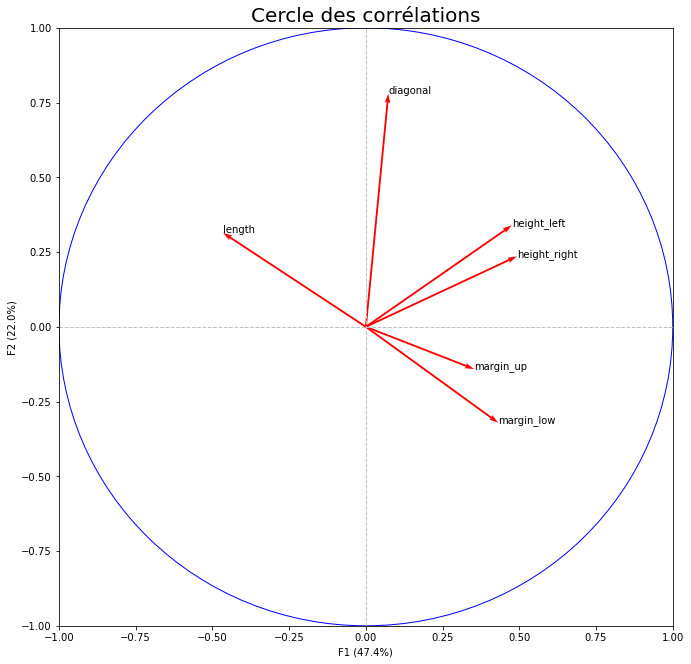

In [11]:
pcs = pcas.components_

fig = plt.subplots(figsize=(11,11))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], 
           angles='xy', scale_units='xy', scale=1, color='r', width= 0.003)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.text(x, y, acp_data.columns[i])
    
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

#Ajout des axes
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Cercle des corrélations', fontsize=20)
plt.xlabel('F{} ({}%)'.format(1, round(100*pcas.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pcas.explained_variance_ratio_[1],1)))


#plt.savefig('cercle_correlations.png')
plt.show()

# 
- Les variables les plus corrélées à F1 sont les hauteurs (height) et les marges (margin), qui sont par ailleurs fortement corrélées entre elles.
- La variable la plus corrélée à F2 est la longueur (lenght)

#### 4. Projection des individus sur le plan factoriel

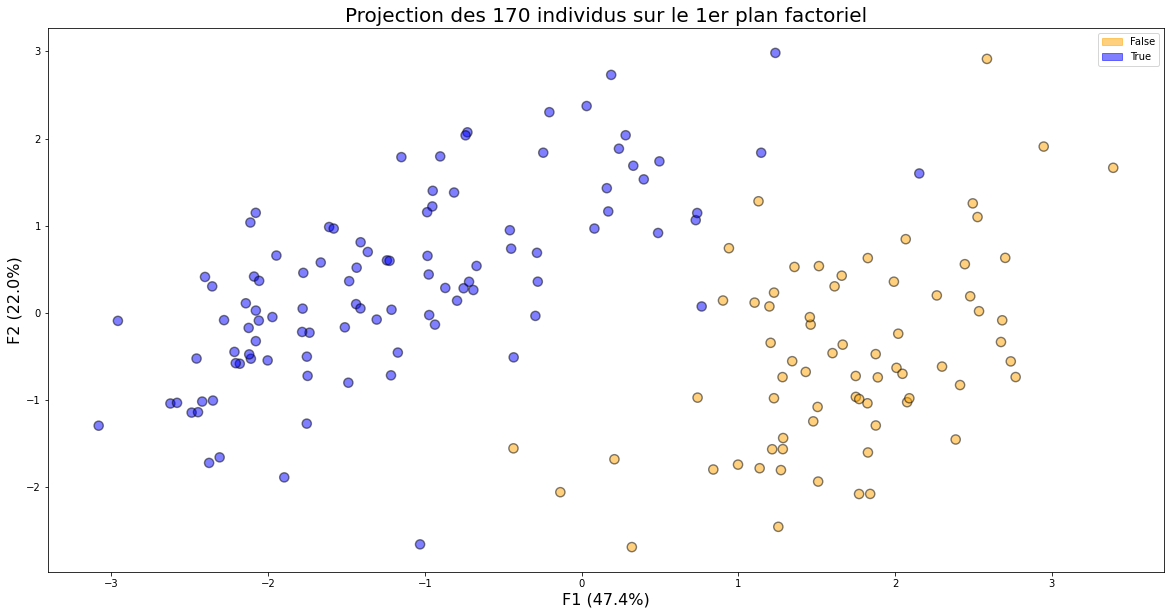

In [12]:
#Coordonnées factorielles 
X_projected = pcas.transform(X_scaled)
plt.figure(figsize=(20, 10))

#Projection des individus sur le premier plan factoriel
colors = ['orange', 'blue']
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=data['is_genuine'].apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

#Labels : nature des billets
lab_0 = mpatches.Patch(color='orange', alpha=0.5, label='False')
lab_1 = mpatches.Patch(color='blue', alpha=0.5, label='True')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pcas.explained_variance_ratio_[0],1)), fontsize=16)
plt.ylabel('F{} ({}%)'.format(2, round(100*pcas.explained_variance_ratio_[1],1)), fontsize=16)
plt.title("Projection des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]), fontsize=20)

#plt.savefig("projection_pca.png")
plt.show()

# 
Suite à la projection sur le premier plan factoriel, on constate : 
- Qu'une "diagonale" sépare les vrais des faux billets.
- L'axe F1 sépare les vrais des faux billets. 
- F2 explique 22% de l’inertie et participe à la représentation des billets.

#### 5. Analyse de la qualité de représentation des individus (COS2).

In [13]:
#Calcul des composantes principales, ici uniquement F1 et F2 seront utiles à l'interprétation attendue.
df_facto = pd.DataFrame(X_projected, index=data.index, columns=["F" + str(i+1) for i in range(6)]).iloc[:, :2]
df_facto

,F1,F2
0,2.153639,1.599709
1,-2.110416,-0.526039
2,-1.973152,-0.048102
3,-2.059795,-0.089105
4,-2.403180,0.412170
...,...,...
165,2.478626,0.189974
166,2.585331,2.914472
167,2.067245,0.845602
168,0.739257,-0.972965


##### Contribution des individus dans l'inertie totale 

In [14]:
di = np.sum(X_scaled**2,axis=1) 
df_contind = pd.DataFrame({'ID':acp_data.index,'d_i':di})
df_contind = df_contind.sort_values("d_i", ascending=False)
df_contind

,ID,d_i
166,166,20.625650
0,0,18.410598
4,4,18.039567
122,122,16.790944
39,39,15.052608
...,...,...
59,59,1.484454
76,76,1.435202
85,85,1.431664
98,98,0.878319


##### Qualité de représentation des individus - COS2

In [15]:
cos2 = X_projected**2
for j in range(2):
    cos2[:,j] = cos2[:,j]/di
df_cos2ind  = pd.DataFrame({'id':acp_data.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]})
df_cos2ind

,id,COS2_1,COS2_2
0,0,0.251929,0.139000
1,1,0.818002,0.050822
2,2,0.784862,0.000466
3,3,0.882856,0.001652
4,4,0.320145,0.009417
...,...,...,...
165,165,0.800651,0.004703
166,166,0.324059,0.411824
167,167,0.498809,0.083461
168,168,0.156908,0.271800


# 
Les individus les mieux représentés ont un cosinus proche de 1 (angle proche de 0). Au contraire, les individus les moins bien réprésentés ont un cosinus proche de 0 (angle proche de 90°).

##### Visualisation de la qualité de représentation des individus sur le 1er plan factoriel

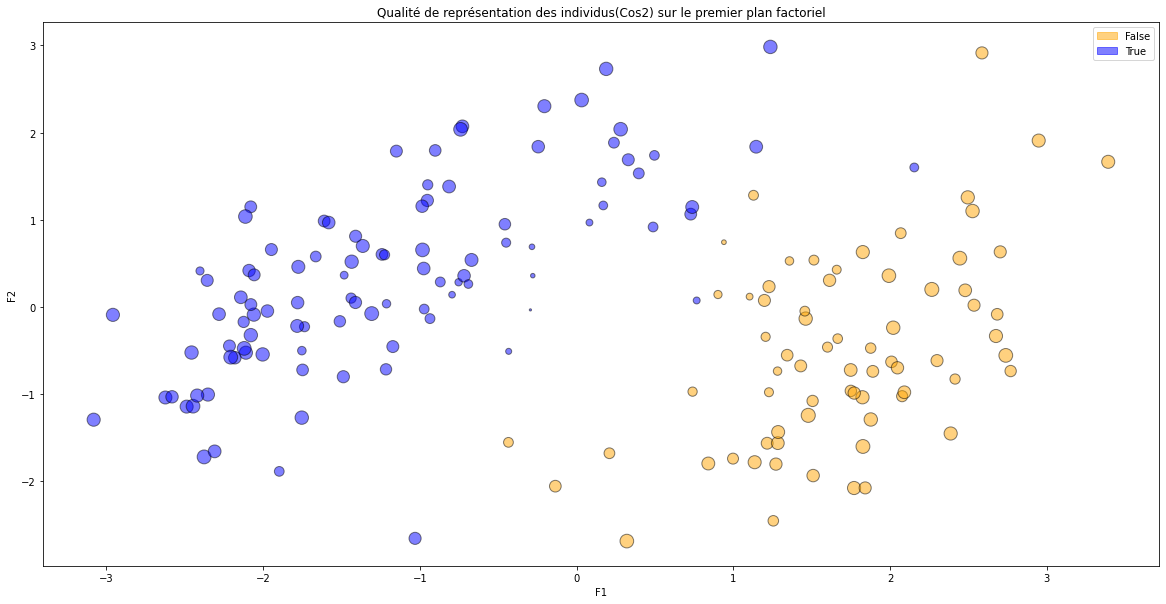

In [16]:
df_cos2ind['COS2_1 + COS2_2'] = df_cos2ind['COS2_1'] + df_cos2ind['COS2_2']

plt.figure(figsize=(20, 10))
colors = ['orange', 'blue']
plt.scatter(df_facto['F1'], df_facto['F2'], c=data['is_genuine'].apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1,
            s=df_cos2ind['COS2_1 + COS2_2']*200)

#Labels de la nature des billets
lab_0 = mpatches.Patch(color='orange', alpha=0.5, label='False')
lab_1 = mpatches.Patch(color='blue', alpha=0.5, label='True')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Qualité de représentation des individus(Cos2) sur le premier plan factoriel')

#plt.savefig('qualite_representation.png')
plt.show()

# 
On remarque donc que les individus sont assez bien représentés. On distingue parfaitement deux groupes d'individus.

##### Contribution des individus aux axes-CTR

In [17]:
(n, p) = data.shape

#Calcul des valeurs propres à partir des valeurs singulières
eigval = pcas.singular_values_**2/n
#contributions aux axes
ctr = X_projected**2
for j in range(2):
    ctr[:,j] = ctr[:,j]/(n*eigval[j])

df_ctr = pd.DataFrame({'id':acp_data.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]})
df_ctr

,id,CTR_1,CTR_2
0,0,0.009584,0.011426
1,1,0.009203,0.001236
2,2,0.008045,0.000010
3,3,0.008767,0.000035
4,4,0.011933,0.000759
...,...,...,...
165,165,0.012694,0.000161
166,166,0.013811,0.037927
167,167,0.008830,0.003193
168,168,0.001129,0.004227


# 
On relève, pour chaque axe, les individus qui ont la plus forte contribution à la formation de l'axe. Il est désormais facile de pouvoir déterminer les individus dont la contribution est supérieure pour donner un sens aux axes.

### K-means

In [18]:
kmeans_data = data.iloc[:, 1:]

In [19]:
#Préparation des données
X = kmeans_data.values
#Centrage et réduction des données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

C:\Users\elodi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


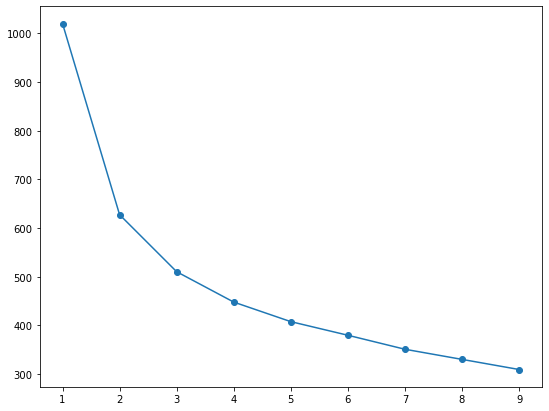

In [20]:
#On crée une liste dans laquelle on stocke les inerties
inerties=[]

#On fait une boucle de 1 à 9 pour tester toutes les possibilités
for k in range(1, 10):
    #pour chaque k, on crée un modèle et on l’ajuste
    km = cluster.KMeans(n_clusters=k)
    km.fit(X_scaled)
    #on stocke l’inertie associée
    inerties.append(km.inertia_)

plt.figure(figsize=(9, 7))
#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.plot(range(1, 10), inerties, marker='o')
plt.savefig('inertie.png')
plt.show()

In [21]:
#Classification des individus par apprentissage non-supervisé K-Means en deux clusters 
cls = cluster.KMeans(n_clusters=2) 
cls.fit(X_scaled)

KMeans(n_clusters=2)

##### Visualisation des clusters sur le premier plan factoriel

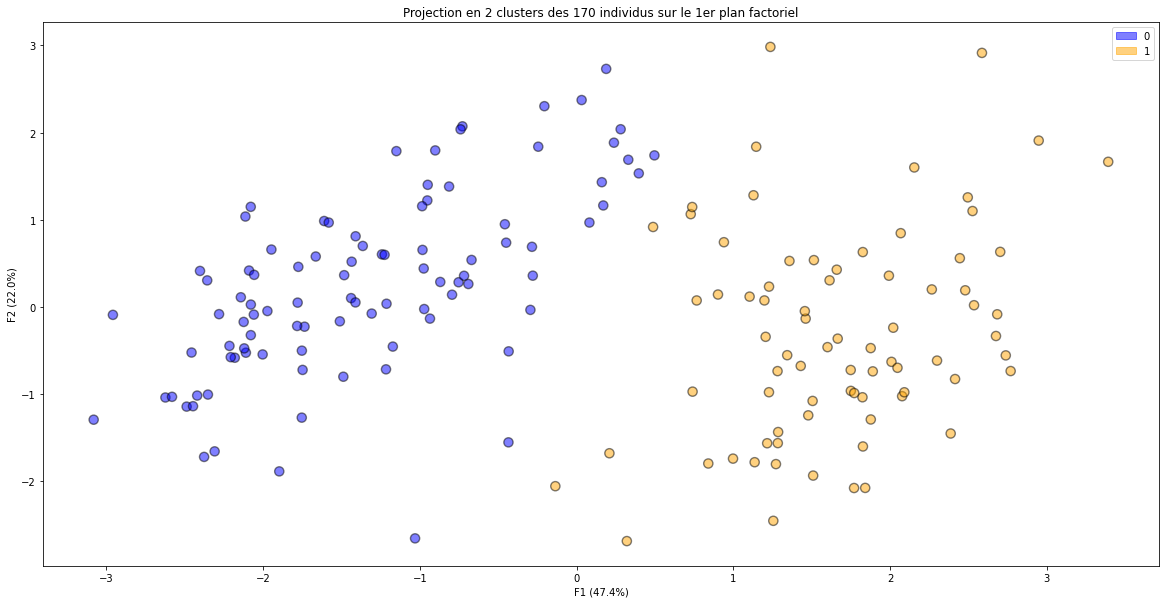

In [22]:
plt.figure(figsize=(20, 10))

categories = cls.labels_
colormap = np.array(['blue', 'orange'])

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[categories], 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

lab_0 = mpatches.Patch(color='blue', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='orange', alpha=0.5, label='1')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pcas.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pcas.explained_variance_ratio_[1],1)))
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

plt.savefig("projection_kmeans.png")
plt.show()

##### Centroïdes des 2 clusters dans sa version centrée/reduite

In [23]:
centroids = cls.cluster_centers_
pd.DataFrame(centroids, columns=kmeans_data.columns)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,0.064022,-0.521604,-0.581005,-0.679283,-0.510041,0.729798
1,-0.079185,0.645141,0.718611,0.840166,0.630841,-0.902645


In [24]:
df_cls = pd.DataFrame(cls.fit_predict(X), columns=['cluster'])
df_cls = pd.concat([df_cls, data], axis=1)
df_cls.head()

,cluster,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,0,True,171.67,103.74,103.70,4.01,2.87,113.29
2,0,True,171.83,103.76,103.76,4.40,2.88,113.84
3,0,True,171.80,103.78,103.65,3.73,3.12,113.63
4,0,True,172.05,103.70,103.75,5.04,2.27,113.55


##### Tableau des correspondances clusters/nature billets

In [25]:
tableau = pd.crosstab(cls.labels_,df_cls['is_genuine'])
tableau.index = ['Cluster 0 - Vrai','Cluster 1 - Faux']
tableau.columns = ['Faux','Vrais']
tableau

,Faux,Vrais
Cluster 0 - Vrai,2,99
Cluster 1 - Faux,68,1
